In [1]:
import sys
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from hoinetx.communities.hy_mmsbm.model import HyMMSBM
from hoinetx.core.hypergraph import Hypergraph
from hoinetx.generation.hy_mmsbm_sampling import HyMMSBMSampler
from hoinetx.linalg.linalg import *
from hoinetx.dynamics.randwalk import *

np.random.seed(123)

In [2]:
# generate list of list of nodes from 0 to 10 with random length from 2 to 5, all nodes in a list must be different and all lists inside the list must be unique
def generate_random_hyperedges_list(num_hyperedges, num_nodes, min_hyperedge_size, max_hyperedge_size):
    hyperedges_list = []
    for i in range(num_hyperedges):
        hyperedge = np.random.choice(num_nodes, np.random.randint(min_hyperedge_size, max_hyperedge_size + 1), replace=False)
        hyperedges_list.append(hyperedge)
    hyperedges_list = list(set(map(tuple, hyperedges_list)))
    return hyperedges_list

edges_list = generate_random_hyperedges_list(200, 40, 2, 5)

#edges_list = list(set(edges_list))

In [120]:
print(f'Number of hlinks: {len(edges_list) }')
#check if all tuples are unique
print(len(edges_list) == len(set(map(tuple, edges_list))))
# check if all tuples in edge_list have unique elements
print(all(len(set(edge)) == len(edge) for edge in edges_list))


Number of hlinks: 200
True
True


In [121]:
HG = Hypergraph(edges_list)

In [5]:
K = transition_matrix(HG).todense()

In [6]:
# check if K is stochastic
print(np.allclose(np.sum(K, axis=0), np.ones(K.shape[0])))


True


In [108]:
# define a function called random_walk that given an object HG of this type hoinetx.core.hypergraph.Hypergraph and a starting node s returns a list of nodes visited by the random walk
def random_walk(HG : Hypergraph, s : int, time : int)->list:
    '''Compute the random walk on the hypergraph.
    
    Parameters
    ----------
    HG : Hypergraph
        The hypergraph on which the random walk is defined.
    s : int
        The starting node of the random walk.
        
    Returns
    -------
    nodes : list
        The list of nodes visited by the random walk.
    '''
    K = np.array(transition_matrix(HG).todense() )
    nodes = [s]
    for t in range(time):
        next_node = np.random.choice(K.shape[0], p=K[:, nodes[-1]])
        nodes.append(next_node)
    return nodes



In [122]:
# find the stationary state of the random walk
def RW_stationary_state(HG : Hypergraph)->np.ndarray:
    '''Compute the stationary state of the random walk on the hypergraph.
    
    Parameters
    ----------
    HG : Hypergraph
        The hypergraph on which the random walk is defined.
        
    Returns
    -------
    stationary_state : np.ndarray
        The stationary state of the random walk on the hypergraph.
    '''
    K = np.array(transition_matrix(HG).todense() )
    stationary_state = np.linalg.solve(np.eye(K.shape[0]) - K.T, np.ones(K.shape[0]))
    stationary_state = stationary_state / np.sum(stationary_state)
    return stationary_state


In [123]:
RW_stationary_state(HG)


array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025])

In [118]:
HG.num_nodes()

10

In [26]:
K[:, nodes[-1]]

matrix([[0.2459893 ],
        [0.05614973],
        [0.06951872],
        [0.0855615 ],
        [0.10160428],
        [0.05882353],
        [0.0828877 ],
        [0.09625668],
        [0.12032086],
        [0.0828877 ]])

In [28]:
nodes

[0, 8, 1]

# Model 3 large deviations

In [32]:
from sklearn.preprocessing import normalize
import networkx as nx
import tqdm.notebook as tqdm
def generate_P_fast_way(N,ntriangles ):
    K = np.ones((N,N)) - np.identity(N)
    if ntriangles >= round( (N-1)/2):
        print(ntriangles, 'triangles...')
        print('too many triangles!')
        return 0
    for i in range(ntriangles):
        K[0][2*i+1] = 3
        K[0][2*i+2] = 3
        K[2*i+1][0] = 3
        K[2*i+2][0] = 3
        K[2*i+1][2*i+2] = 3
        K[2*i+2][2*i+1] = 3

    P = normalize(K, axis=1, norm='l1')
    return P

def generate_graph_fixed_triangles(N,ntriangles):
    if ntriangles >= round( (N-1)/2):
        print('too many triangles!')
        return 0
    #print(ntriangles, 'triangles...')
    hedge_list = []
    # possible nodes is a list of all adjacent pair not overlapping, e.g. [[1,2],[3,4]...]
    possible_triangles = [[0,i,i+1] for i in range(1,N,2) ]
   
    for i in range(ntriangles):
        hedge_list.append(possible_triangles[i])

    G = nx.complete_graph(N, create_using=None)
    link_list =list(G.edges() )
    for link in link_list:
        hedge_list.append([ link[0], link[1] ])
    #print('generating incidence matrix...')
    #print(hedge_list)

    # Incidence matrix
    e = np.zeros((N, len(hedge_list) ))
    for c in range(len(hedge_list)):
        for r in range(N):
            if r in hedge_list[c]:
                e[r][c] = 1



    C = np.zeros(  (len(hedge_list), len(hedge_list) ) )
    for alpha in tqdm.tqdm(range(len(hedge_list))):
        for beta in range( alpha,len(hedge_list)):
            C[alpha][beta] = sum( [e[i][alpha]*e[i][beta] for i in range(N) ] )
            C[beta][alpha] =C[alpha][beta]

    # Degree matrix
    #print('generating degree matrix...')
    K = np.zeros((N, N ))
    for i in range(N):
        for j in range(N):
            if i != j:
                K[i][j] = sum([(C[alpha][alpha] -1)*e[i][alpha]*e[j][alpha] for alpha in range(len(hedge_list)) ])


    P = normalize(K, axis=1, norm='l1')
    return P



In [39]:
P1 =generate_P_fast_way(1000, 499)
# P2 = generate_graph_fixed_triangles(10, 4)
# np.allclose(P1, P2)
N = 1000
possible_triangles = [[0,i,i+1] for i in range(1,N-1,2) ]
len(possible_triangles)

499

In [31]:
# model 3 incidence matrix
N = 10
ntriangles = 5
hedge_list = []
# possible nodes is a list of all adjacent pair not overlapping, e.g. [[1,2],[3,4]...]
possible_triangles = [[0,i,i+1] for i in range(1,N,2) ]

for i in range(ntriangles):
    hedge_list.append(possible_triangles[i])

G = nx.complete_graph(N, create_using=None)
link_list =list(G.edges() )
for link in link_list:
    hedge_list.append([ link[0], link[1] ])

In [28]:
possible_triangles

[[0, 1, 2], [0, 3, 4], [0, 5, 6], [0, 7, 8], [0, 9, 10]]

In [20]:
hedge_list

[[0, 1, 2],
 [0, 3, 4],
 [0, 5, 6],
 [0, 7, 8],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 9],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 9],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 9],
 [4, 5],
 [4, 6],
 [4, 7],
 [4, 8],
 [4, 9],
 [5, 6],
 [5, 7],
 [5, 8],
 [5, 9],
 [6, 7],
 [6, 8],
 [6, 9],
 [7, 8],
 [7, 9],
 [8, 9]]

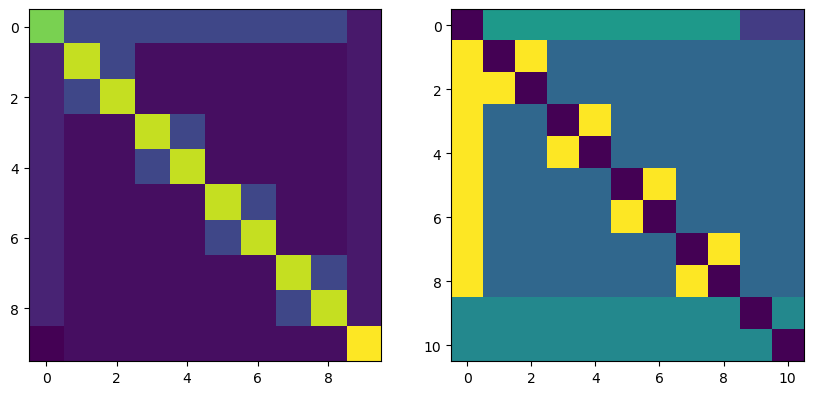

In [24]:
HG = Hypergraph(hedge_list)
K = transition_matrix(HG).todense()
# plot a subfigures with imshow K and P1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(K)
ax[1].imshow(P1)

